In [58]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import math
import datetime as dt
from datetime import date

In [59]:
## 시각화
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (13,7)

In [60]:
## 평가모듈
import evaluation_module as evm

## Data

In [61]:
date_idx = date.today().strftime('%Y-%m-%d')

score_ori = pd.read_csv(f'data/result_{date_idx}.csv', index_col=0)
score_ori.index = pd.to_datetime(score_ori.index)

## assets = ['SPY', 'QQQ', 'VEA', 'VWO', 'TLT', 'IEF', 'SHY', 'IAU']
assets = ['SPY', 'QQQ', 'VEA', 'VWO', 'TLT', 'IEF', 'SHY']
assets_hat = [i + '_hat' for i in assets]

score_df = score_ori[assets_hat]
score_df.columns = assets

In [62]:
asset_ori = pd.read_csv('data/assets.csv', index_col=0)
asset_ori.index = pd.to_datetime(asset_ori.index)
asset_df = asset_ori.resample('M').last()
rets = asset_df.pct_change().dropna()
rets = rets[assets]

## Score -> Weight

### Score 차등 배분 방식

In [63]:
## 음수자산 0
df = score_df.dropna().copy()
for col in df.columns:
    df[col][df[col]<=0] = 0

## 모든자산 0 => 단기채 1
df['SHY'][df.sum(axis=1) <= 0] = 1

## 예측값 기준 차등배분
df_w = (df.T/df.sum(axis=1)).T

In [64]:
## 이번달 자산배분
df_w.tail(5)

,SPY,QQQ,VEA,VWO,TLT,IEF,SHY
0,,,,,,,
2021-12-31,0.000000,0.106355,0.751916,0.0,0.0,0.078298,0.063431
2022-01-31,0.000000,0.000000,0.936839,0.0,0.0,0.007315,0.055845
2022-02-28,0.381845,0.153042,0.445966,0.0,0.0,0.000000,0.019147
2022-03-31,0.478964,0.154998,0.347084,0.0,0.0,0.000000,0.018955
2022-04-30,0.432665,0.000000,0.524269,0.0,0.0,0.000000,0.043067


### Score 최유리 집중 방식

In [65]:
df = score_df.dropna().copy().T
## 상위1종목
top5_fun = lambda srs : srs.sort_values(ascending = False).head(1).index
for col in df.columns:
    trgt = top5_fun(df[col])
    df[col] = 0 ## 투자제외 종목
    df[col][trgt] = 1 ## 투자대상 종목 표기
df_w2 = df.T

In [66]:
## 이번달 자산배분
df_w2.tail(5)

,SPY,QQQ,VEA,VWO,TLT,IEF,SHY
0,,,,,,,
2021-12-31,0,0,1,0,0,0,0
2022-01-31,0,0,1,0,0,0,0
2022-02-28,0,0,1,0,0,0,0
2022-03-31,1,0,0,0,0,0,0
2022-04-30,0,0,1,0,0,0,0


## 성능평가

### 요약

In [67]:
## ML: 스코어 차등배분 방식
rets_w1 = (rets * df_w).dropna().sum(axis=1)
## ML: 스코어 집중 방식
rets_w2 = (rets * df_w2).dropna().sum(axis=1)
## BM: 동일가중 포트폴리오
rets_bm = rets.mean(axis=1)[rets_w1.index]
## BM2: QQQ B&H
rets_bm2 = rets['QQQ'][rets_w1.index]

In [68]:
df_rets = pd.DataFrame([rets_w1, rets_w2, rets_bm, rets_bm2],
                       index=['GRU1', 'GRU2', 'BM', 'BM2']).T.dropna()
report = evm.get_report2(df_rets)
print('전기간 성능평가')
report

전기간 성능평가


,Return,Volatility,Sharpe,MDD,Win
GRU1,0.2203,0.1139,1.9348,-0.0656,0.7296
GRU2,0.2809,0.1565,1.7945,-0.0640,0.6918
BM,0.0952,0.0824,1.1550,-0.0637,0.6478
BM2,0.2146,0.1653,1.2980,-0.1283,0.6478


In [69]:
df_rets = pd.DataFrame([rets_w1, rets_w2, rets_bm, rets_bm2],
                       index=['GRU1', 'GRU2', 'BM', 'BM2']).T.dropna()
report = evm.get_report2(df_rets.tail(12*5))
print('최근5년(Test&Valid기간) 성능평가')
report

최근5년(Test&Valid기간) 성능평가


,Return,Volatility,Sharpe,MDD,Win
GRU1,0.1767,0.0981,1.8014,-0.0656,0.7000
GRU2,0.2302,0.1331,1.7290,-0.0640,0.6667
BM,0.0855,0.0829,1.0310,-0.0637,0.6667
BM2,0.2204,0.1804,1.2215,-0.1283,0.6667


### 추이

In [70]:
## GRU1, GRU2만 남김
df_rets_clean = df_rets[['GRU1', 'GRU2', 'BM', 'BM2']]

<AxesSubplot:>

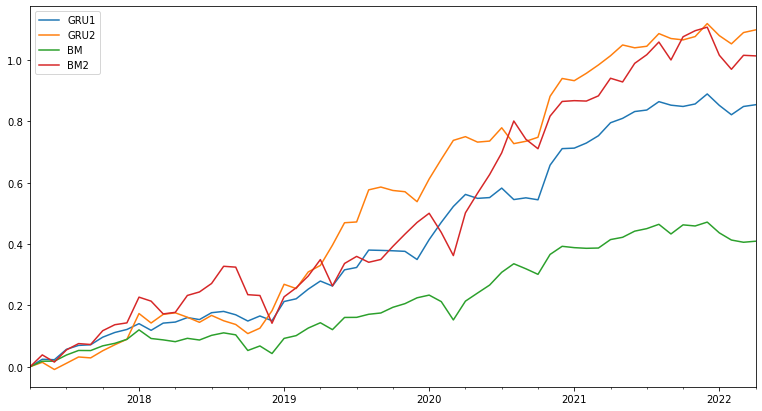

In [71]:
df_value = evm.get_df_val(df_rets_clean.tail(12*5))
np.log(df_value).plot()

### MDD

In [72]:
df_dd = evm.get_dd(df_value)

<AxesSubplot:>

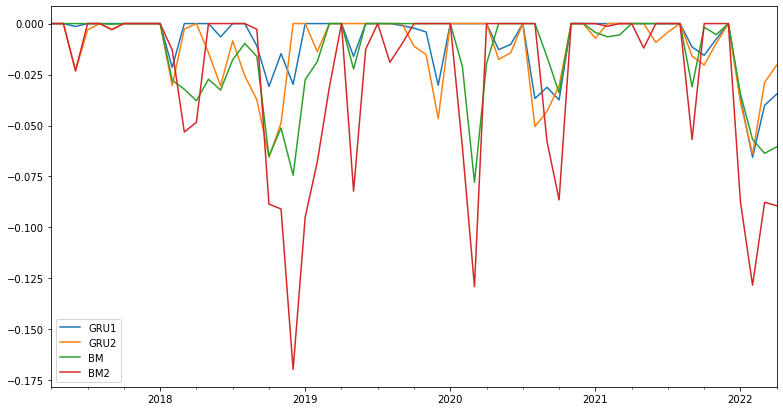

In [73]:
df_dd.plot()

### 배분율

In [74]:
df_w.mean()

SPY    0.177833
QQQ    0.190662
VEA    0.156615
VWO    0.104356
TLT    0.214516
IEF    0.125467
SHY    0.030551
dtype: float64

In [75]:
df_w2.mean()

SPY    0.113208
QQQ    0.157233
VEA    0.245283
VWO    0.094340
TLT    0.339623
IEF    0.050314
SHY    0.000000
dtype: float64

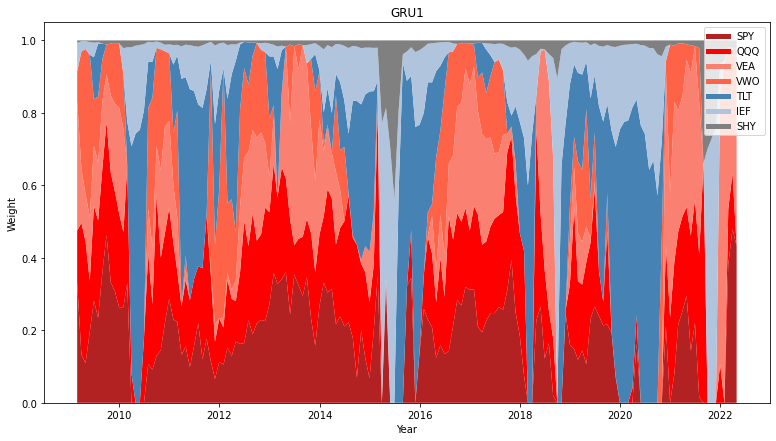

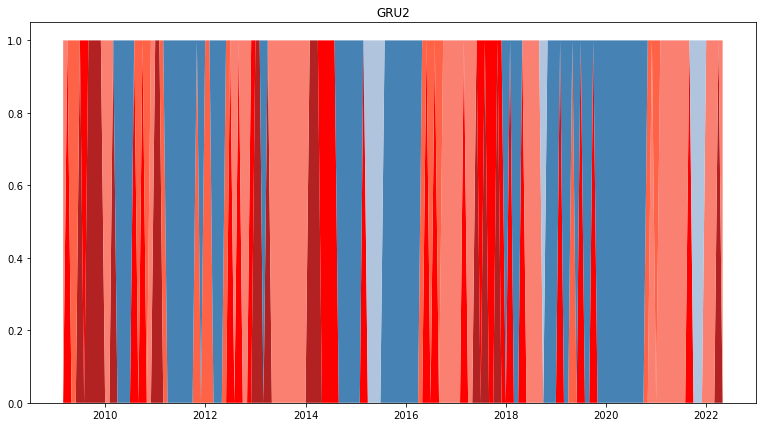

In [76]:
colors = ['#B22222', 'red', '#FA8072', '#FF6347', '#4682B4', '#B0C4DE', 'gray', '#FF8C00']

plt.plot([], [], color='#B22222', label='SPY', linewidth=5)
plt.plot([], [], color='red', label='QQQ', linewidth=5)
plt.plot([], [], color='#FA8072', label='VEA', linewidth=5)
plt.plot([], [], color='#FF6347', label='VWO', linewidth=5)
plt.plot([], [], color='#4682B4', label='TLT', linewidth=5)
plt.plot([], [], color='#B0C4DE', label='IEF', linewidth=5)
plt.plot([], [], color='gray', label='SHY', linewidth=5)
## plt.plot([], [], color='#FF8C00', label='IAU', linewidth=5)
plt.xlabel('Year')
plt.ylabel('Weight')


## GRU1
plt.stackplot(df_w.index, df_w['SPY'], df_w['QQQ'], df_w['VEA'],
              df_w['VWO'], df_w['TLT'], df_w['IEF'], df_w['SHY'], colors = colors)
plt.legend()
plt.title('GRU1')
plt.show()

## GRU2
plt.stackplot(df_w2.index, df_w2['SPY'], df_w2['QQQ'], df_w2['VEA'],
              df_w2['VWO'], df_w2['TLT'], df_w2['IEF'], df_w2['SHY'], colors = colors)
plt.title('GRU2')
plt.show()